# Draft

Author's notes: 
- Remove Introduction headings. Replace it with just the opening.
- Check if I will need to check for outliers in the dataset and will checking for outliers be useful.

In [1]:
import pandas as pd
df = pd.read_csv('./globalterrorismdb.csv', low_memory=False, engine='c')

## Overview

The **Global Terrorism Database** (GTD) is an extensive resource that tracks terrorist attacks across the world, offering data from over 200,000 incidents between 1970 and 2020. This dataset, maintained by the National Consortium for the Study of Terrorism and Responses to Terrorism (START) at the University of Maryland, serves as an invaluable tool for understanding the global patterns, causes, and consequences of terrorism. By analyzing the GTD, we gain insights into trends such as the methods, regions, and targets involved in terrorism, as well as the political, economic, and social contexts that drive these violent acts.

In this project, we leverage the GTD to explore the geographical hotspots of terrorism, uncover trends over time, and analyze the effectiveness and tactics of terrorist groups. With over four decades of data at our disposal, the goal is to identify patterns in terrorist activity, visualize global hotspots, and discuss key findings that contribute to understanding the global impact of terrorism.

The insights from this data can serve as a foundation for policymakers, security agencies, and researchers aiming to mitigate terrorism’s impact. By focusing on trends over time, geographical distribution, and methods of attack, we aim to provide a comprehensive view of the state of terrorism worldwide, offering a clear perspective on both historical and emerging trends.

## Preprocessing Phase
After selecting the necessary columns for analysis, the next steps in the data cleaning process involve addressing missing values, handling incorrect or inconsistent data, and preparing the data for analysis. Here’s a breakdown of the key steps I took:

One of the first things I had to tackle was dealing with missing or null values. This is common in large datasets, especially one like the Global Terrorism Database (GTD), where certain data points might be missing due to incomplete reports or the limitations of data collection in conflict zones. Missing values can lead to biased or inaccurate analysis, so it’s important to handle them carefully.

In the case of this project, where we are exploring terrorism hotspots, trends over time, and methods of attack, the missing data could significantly impact our insights if not addressed properly.

In [8]:
# this gets the number of null values for each attribute(column)
df.isnull().sum() 

iyear                   0
imonth                  0
iday                    0
country_txt             0
region_txt              0
latitude             4691
longitude            4692
attacktype1_txt         0
weaptype1_txt           0
targtype1_txt           0
targsubtype1_txt    11839
target1               637
natlty1_txt          2014
gname                   0
nkill               12527
nwound              19936
suicide                 0
success                 0
dtype: int64

From the output above, we can see that some columns have null values while 11 columns no null values.

- Latitude and longitude have over 4600+ missing values. Since these columns are crucial for mapping geographical hotspots, I decided to drop rows with missing latitude and longitude data to ensure accurate location-based analysis.

- For columns like nkill and nwound (fatalities and wounded), which had over 12,000 and 19,000 missing values, I filled the missing values with 0, assuming no casualties or injuries were reported for these incidents. This approach preserved the data for further analysis without excluding important rows.

- For columns like targsubtype1_txt (target subtype) and natlty1_txt (target nationality), I filled missing values with "Unknown", as these fields weren't critical for the overall analysis but still added value for categorization and grouping.

 To clean up duplicates, I removed redundant rows using df.drop_duplicates(inplace=True). Lastly, I standardized columns like attacktype1_txt by converting all text to lowercase and stripping extra spaces to ensure consistency across categories. Here's the code I used for these steps:

In [2]:
# Drop rows with missing latitude and longitude
df = df.dropna(subset=['latitude', 'longitude'])

# Fill missing values for fatalities and injuries with 0
df['nkill'] = df['nkill'].fillna(0)
df['nwound'] = df['nwound'].fillna(0)

# Fill missing categorical values with 'Unknown'
df['targsubtype1_txt'] = df['targsubtype1_txt'].fillna('Unknown')
df['natlty1_txt'] = df['natlty1_txt'].fillna('Unknown')

# Remove duplicate rows
df = df.drop_duplicates()

# Standardize text columns
df['attacktype1_txt'] = df['attacktype1_txt'].str.lower().str.strip()



To streamline the dataset and focus on the project's goals, I narrowed it down to only the columns essential for analyzing trends, hotspots, and attack characteristics. These included fields for date, location, attack type, targets, and impact, such as `iyear`, `country_txt`, `attacktype1_txt`, `nkill`, and `gname`. By selecting just these columns, I ensured the dataset remained manageable and directly relevant to uncovering insights about terrorism.

In [ ]:
needed_columns = [
    'iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'latitude', 'longitude',
    'attacktype1_txt', 'weaptype1_txt', 'targtype1_txt', 'targsubtype1_txt', 'target1', 'natlty1_txt', 
    'gname', 'nkill', 'nwound', 'suicide', 'success'
]
df = df[needed_columns]
df.head()

After preprocessing the structure of our database looks like this:

In [19]:
row, column = df.shape
print(f"Number of rows: {row}")
print(f"Number of columns: {column}")

Number of rows: 194383
Number of columns: 18


With that, we have `3498894` cells. 

## Analysis and Insight

#### Trend over the years

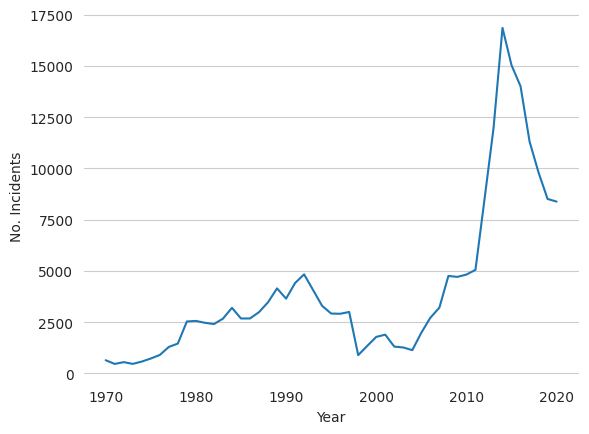

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

yearly_trends = df.groupby('iyear').size().reset_index(name='incidents')

custom = {
    "axes.edgecolor": "white",
    "grid.linestyle": "solid",
    
}
sns.set_style('whitegrid', rc=custom)

sns.lineplot(data=yearly_trends, x='iyear', y='incidents')
# plt.title('Trend of Terrorist Incidents Over the Years')
plt.xlabel('Year')
plt.ylabel('No. Incidents')
plt.grid(axis='x')
plt.show()

#### Regional Comparison

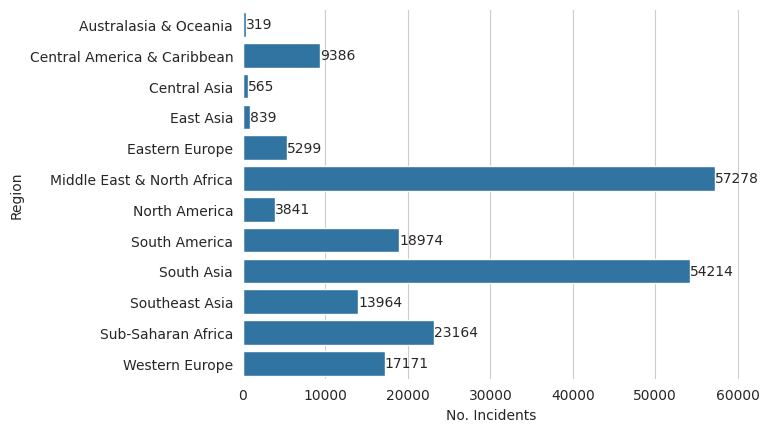

In [23]:
regional_trends = df.groupby('region_txt').size().reset_index(name='incidents')
sns.set_color_codes("muted")
ax = sns.barplot(data=regional_trends, x='incidents', y='region_txt')
ax.bar_label(ax.containers[0])
plt.xlabel('No. Incidents')
plt.ylabel('Region')
plt.show()


#### Common Attack Methods

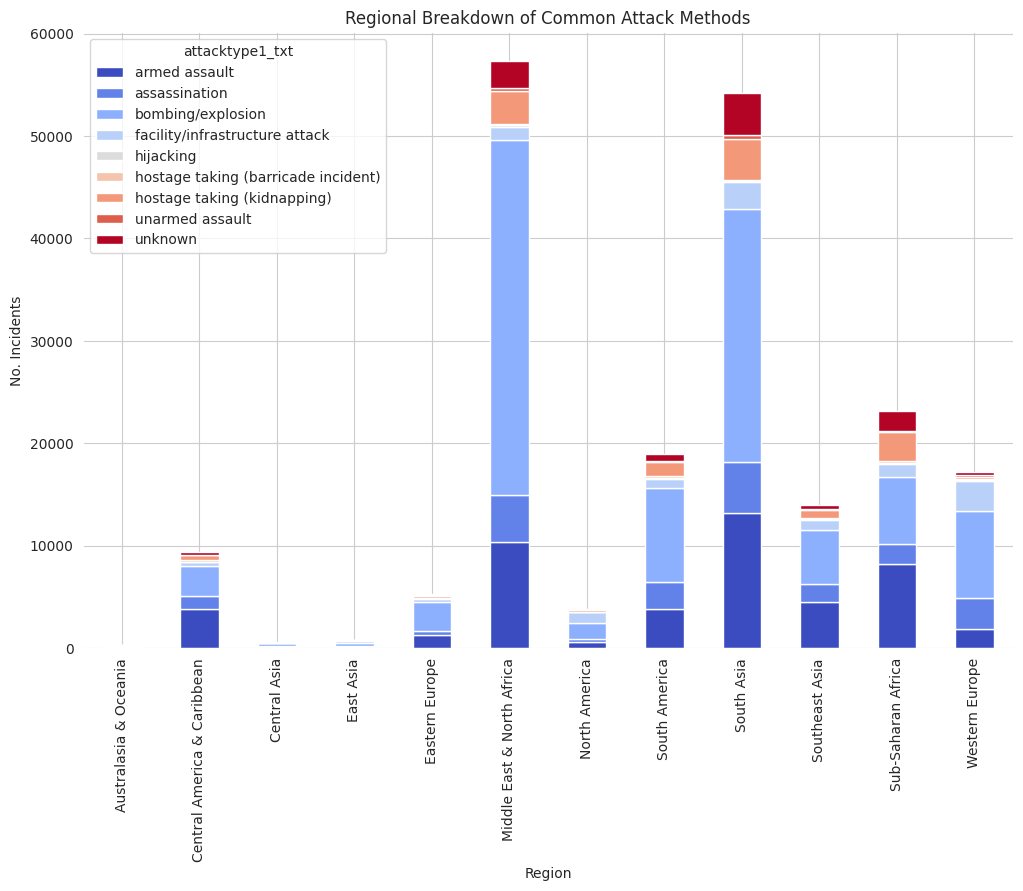

In [10]:
attack_type_data = df.groupby(['region_txt', 'attacktype1_txt']).size().unstack()
attack_type_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='coolwarm')
plt.title('Regional Breakdown of Common Attack Methods')
plt.xlabel('Region')
plt.ylabel('No. Incidents')
plt.show()


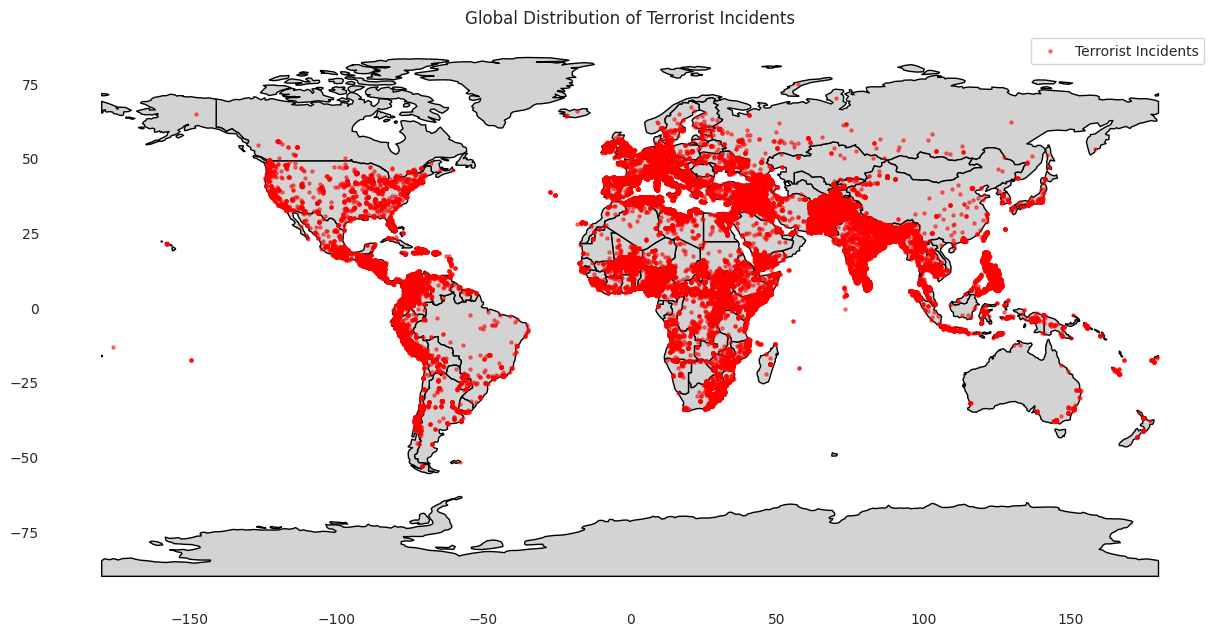

In [6]:
import geopandas as gpd
# Load a world map shapefile (comes with GeoPandas)
world = gpd.read_file("./ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Convert your dataset into a GeoDataFrame
# Assuming your DataFrame is named df and has 'latitude' and 'longitude' columns
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs="EPSG:4326"  # WGS84 Coordinate Reference System
)

# Plot the world map
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey', edgecolor='black')  # Base map

# Overlay terrorism data
gdf.plot(ax=ax, markersize=5, color='red', alpha=0.5, label='Terrorist Incidents')
ax.grid(False)
# Add a legend and title
plt.legend()
plt.title('Global Distribution of Terrorist Incidents')
plt.show()

#### Correlation between incidents and casualties


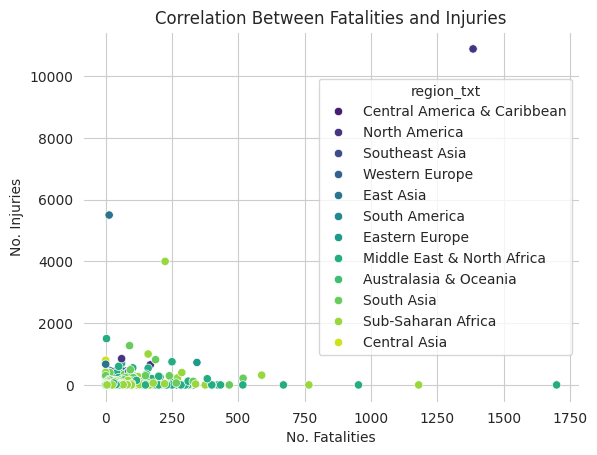

In [33]:
# Scatter plot for fatalities vs. injuries
sns.scatterplot(data=df, x='nkill', y='nwound', hue='region_txt', palette='viridis')

# Add titles and labels
plt.title('Correlation Between Fatalities and Injuries')
plt.xlabel('No. Fatalities')
plt.ylabel('No. Injuries')
plt.grid(True)
plt.show()

In [27]:
correlation = df['nkill'].corr(df['nwound'])
print(f"Correlation: {correlation}")

Correlation: 0.4408038022325402


The correlation value 

#### Group-Level Analysis

In [12]:
# Pivot table for heatmap (rows: groups, columns: years)
group_yearly_activity = df.pivot_table(index='gname', columns='iyear', aggfunc='size', fill_value=0)

# Increase figure size (larger width and height)
plt.figure(figsize=(18, 12))  # Adjust the size (width, height) as needed
sns.heatmap(group_yearly_activity, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5)

# Title and labels
plt.title('Group Activity Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Terrorist Group', fontsize=14)

# Display the plot
plt.show()
